<a href="https://colab.research.google.com/github/GitMarco27/TMML/blob/main/Notebooks/011_Dtw_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 Minutes Machine Learning
## FROM Episode 11: Dtw Loss Function

Slightly modified from
#### Marco Sanguineti, 2021
---


Tested on PC win1064-1036593 tf262 (note this is the lower case version!!)
18th August 2023

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.6.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Creating data

---
This works nicely


(1000, 500)

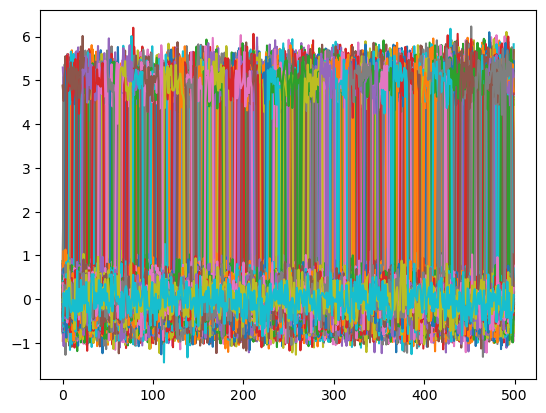

In [6]:
import random
n=500
WINDOW=n
records=1000
noise_amplitude = 0.3  # Adjust the amplitude of the noise

xs=[]
ys=[]
for i in range(records):
    #Draw a straight line
    line = [0 for val in range(n)]
    opens = [5 for val in range(n)]
    # hHw many events?
    events = random.randint(0,5)
    lengths = np.random.randint(1,high=math.floor(WINDOW/20),size=events)
    miin=0
    
    for event in range(events):
        if miin+lengths[event] < n:
            start = random.randint(miin,n-lengths[event])
            fin = start + lengths[event]
            miin = fin
            line[start:fin] = opens[start:fin]

    # Add noise to the sine wave            
    random_noise = np.random.normal(0, noise_amplitude, n)   

    xs.append(line + random_noise)
    ys.append(line)
    plt.plot(xs[i])
    
np.asarray(xs).shape


Create a couple of curves as actual tensors

In [7]:
#x = tf.Variable(np.cos(np.linspace(0, n)*3.14/180).reshape(1, -1))
#have made a load of them now
# WHY ARE WE making all these tf.variables if we just numpy them before run!!?
#x = tf.Variable(np.asarray(xs).reshape(batch_size,-1))
#y = tf.Variable(np.asarray(ys).reshape(batch_size,-1))
# Convert data to TensorFlow Tensors
x = tf.convert_to_tensor(np.asarray(xs).reshape(records,WINDOW,1), dtype=tf.float32)
y = tf.convert_to_tensor(np.asarray(ys).reshape(records,WINDOW,1), dtype=tf.float32)


For a look-see, convery back to numpy and plot'em

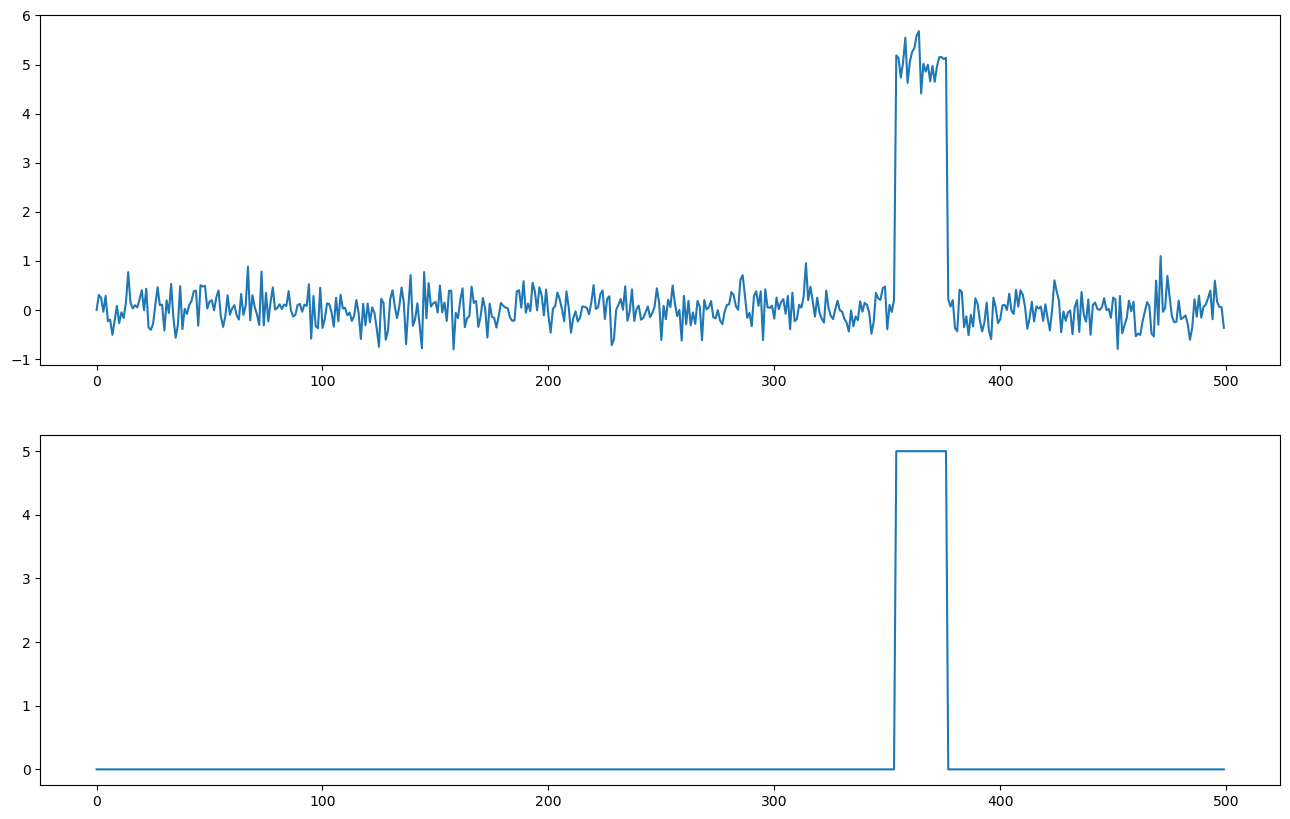

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(16, 10))
#just plot the first x!
axs[0].plot(x.numpy()[0].reshape(-1))
axs[1].plot(y.numpy()[0].reshape(-1))
plt.show()

Create the loss class
and just see if it works by calling with x as the data and y as the prediction

So it works and returns a suitable value; of course converted to a regular variable to print.

## Basic Stacked Autoencoder Implementation


---
A simple (encoder) NN model with just one layer and 10 fully connected neurones

In [9]:
drop=0.2

VAEmodel = Sequential(
    [
        layers.Input(shape=(WINDOW,1) ),
        layers.Conv1D(
            filters=16, kernel_size=8, padding="valid", strides=1, activation="relu",
            name="CONV1"),
        layers.Dense(16*8),
        layers.Dropout(rate=drop),
        layers.Conv1D(
            filters=32, kernel_size=6, padding="valid", strides=1, activation="relu",
            name="CONV2"),
        layers.Dropout(rate=drop),           
               
        layers.Conv1D(
            filters=64, kernel_size=4, padding="valid", strides=1, activation="relu",
            name="CONV3"),
         layers.Dropout(rate=drop),       
        
        layers.Conv1DTranspose(
            filters=64, kernel_size=4, padding="valid", strides=1, activation="relu",
            name="CONVt1"),
        layers.Dropout(rate=drop),
        layers.Conv1DTranspose(
            filters=32, kernel_size=6, padding="valid", strides=1, activation="relu",
            name="CONVt2"),
        layers.Dropout(rate=drop),
        layers.Conv1DTranspose(
            filters=64, kernel_size=8, padding="valid", strides=1, activation="relu",
            name="CONVt3"),
        layers.Dropout(rate=drop),

        layers.Conv1DTranspose(filters=2, kernel_size=7, padding="same",
                name="CONVtFINAL3") 
    ]
)
#LR=0.001
#My_Adam=tf.keras.optimizers.Adam(learning_rate=LR, name="My_Adam")
#model.compile(optimizer=My_Adam, loss="mae")
#AE_CNN.compile(optimizer="Adam", loss="mae")
#print(f"Input shape=[{windows.shape[0]}][{windows.shape[1]}][{windows.shape[2]}]")
#model.summary()

In [10]:
x.shape

TensorShape([1000, 500, 1])

...and a matching decoder....

In [11]:
#Alternative version based on my attempt.
class DtwLossKG(tf.keras.losses.Loss):
    def __init__(self, norm="L1", window_size=0.1, force_symmetry=False):  #can add other generic setups here like batch id desired
        super(DtwLossKG, self).__init__()
        self.norm = norm # either "L1" or "L2"
        self.window_size = window_size # either a fixed integer or a relative float
        self.force_symmetry = force_symmetry # either True or False
        
    def call(self, y_true, y_predict):
        LB_sum = tf.constant(0.0, dtype=tf.float32)  # Initialize the loss sum
        batch_size=y_predict.shape[0]
        for batch in range(batch_size):
            s1=y_true[batch,:,0] # Shape is 1 1D array!!
            s2=y_predict[batch,:,0]
            # compute window size based on input
            if isinstance(self.window_size, int):
                r = tf.constant(self.window_size, dtype=tf.int32)
            elif isinstance(self.window_size, float):
                r = tf.cast(tf.math.round(self.window_size * len(s1)), dtype=tf.int32)
            else:
                raise ValueError("Invalid window size")
            # compute lower bound based on norm
            if self.norm == "L1":
                LB_sum += self.LB_Keogh_L1(s1, s2, r)
                if self.force_symmetry:
                    LB_sum += self.LB_Keogh_L1(s2, s1, r)
            elif self.norm == "L2":
                LB_sum += self.LB_Keogh_L2(s1, s2, r)
                if self.force_symmetry:
                    LB_sum += self.LB_Keogh_L2(s2, s1, r)
            else:
                raise ValueError("Invalid norm")
        return LB_sum/tf.cast(batch_size,dtype=tf.float32)

    def LB_Keogh_L1(self, x, y, r):
        # compute L1 norm lower bound
        LB_sum = tf.constant(0.0, dtype=tf.float32)
        for index in range(len(x)):
            ind=tf.cast(index,dtype=tf.int32)
            i=tf.cast(x[ind],dtype=tf.float32)
            lower_bound = tf.reduce_min(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            upper_bound = tf.reduce_max(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            if i > upper_bound:
                LB_sum += tf.abs(i - upper_bound)
            elif i < lower_bound:
                LB_sum += tf.abs(i - lower_bound)
        return LB_sum

    def LB_Keogh_L2(self, x, y, r):
        # compute L2 norm lower bound
        LB_sum = tf.constant(0.0, dtype=tf.float32)
        for index in range(len(x)):
            ind=tf.cast(index,dtype=tf.int32)
            i=tf.cast(x[ind],dtype=tf.float32)
            lower_bound = tf.reduce_min(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            upper_bound = tf.reduce_max(y[(ind - r if ind - r >= 0 else 0):\
                                           (ind + r if ind + r < len(x) else len(x))])
            if i > upper_bound:
                LB_sum += tf.math.square(i - upper_bound)
            elif i < lower_bound:
                LB_sum += tf.math.square(i - lower_bound)
        return LB_sum

    
lossKG = DtwLossKG(norm="L2", window_size=0.1, force_symmetry=True)
VAEmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss="mse")




In [12]:
VAEhistory=VAEmodel.fit(x, y, epochs=200, batch_size=10)

Epoch 1/200
100/100 [==============================] - 9s 9ms/step - loss: 0.2018
Epoch 2/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0681
Epoch 3/200
100/100 [==============================] - 1s 12ms/step - loss: 0.0502
Epoch 4/200
100/100 [==============================] - 1s 10ms/step - loss: 0.0408
Epoch 5/200
100/100 [==============================] - 1s 9ms/step - loss: 0.0352
Epoch 6/200
100/100 [==============================] - 1s 10ms/step - loss: 0.0302
Epoch 7/200
100/100 [==============================] - 1s 11ms/step - loss: 0.0298
Epoch 8/200
100/100 [==============================] - 1s 10ms/step - loss: 0.0245
Epoch 9/200
100/100 [==============================] - 1s 10ms/step - loss: 0.0231
Epoch 10/200
100/100 [==============================] - 1s 12ms/step - loss: 0.0198
Epoch 11/200
100/100 [==============================] - 1s 9ms/step - loss: 0.0186
Epoch 12/200
100/100 [==============================] - 1s 9ms/step - loss: 0.0167
Epoch

KeyboardInterrupt: 

NameError: name 'VAEhistory' is not defined

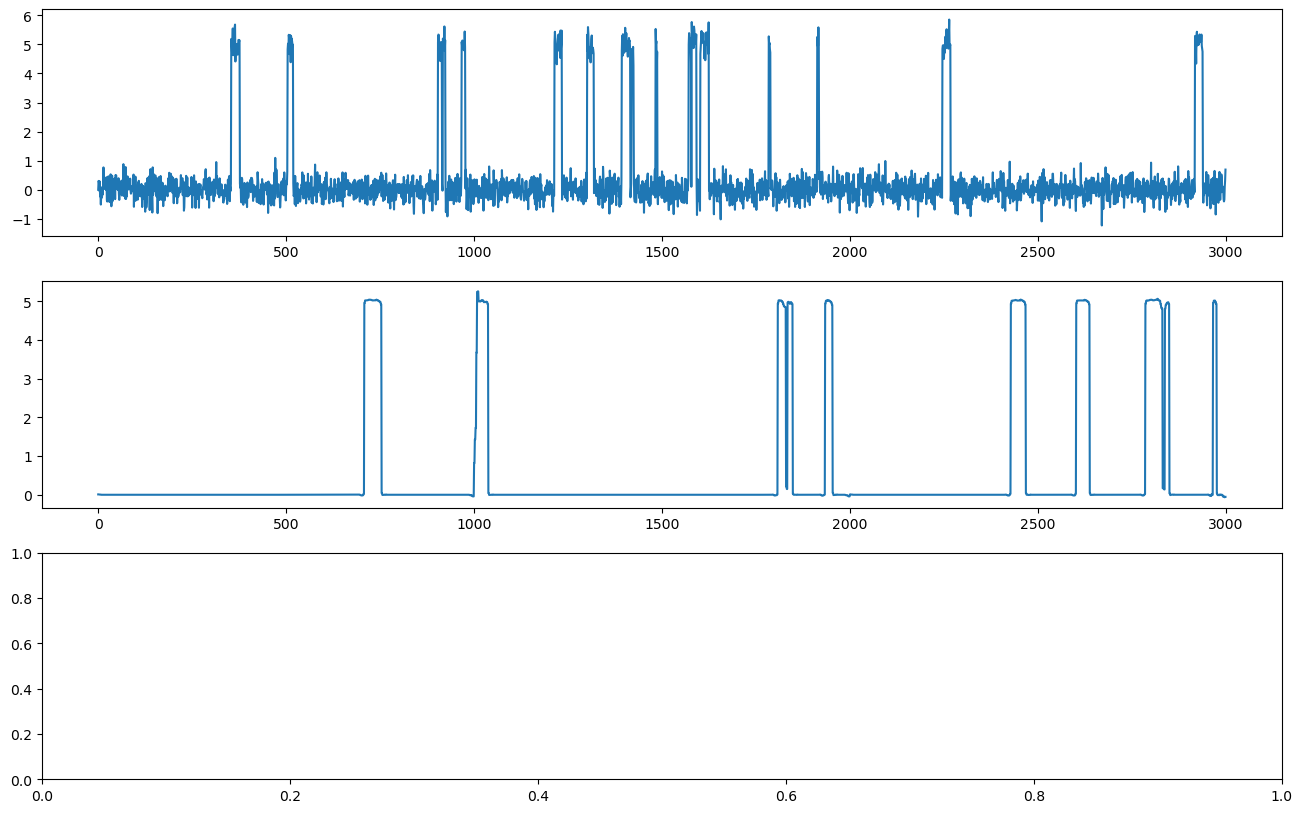

In [13]:
import math
fig, axs = plt.subplots(nrows=3, figsize=(16, 10))
axs[0].plot(x.numpy().reshape(-1)[:3000])
axs[1].plot(VAEmodel(x.numpy()).numpy().reshape(-1)[:3000])
axs[2].plot(VAEhistory.history["loss"])
#axs[2].set_ylim([0,math.ceil(max(history2.history["loss"]))])
plt.show()